In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import xarray as xr
import arviz as az

np.set_printoptions(suppress=True, linewidth=120)

In [2]:
import statsmodels.api as sm
# Load data
mdata = sm.datasets.macrodata.load().data
# Compute annualized consumer price inflation
y = np.log(mdata['cpi']).diff().iloc[1:] * 400

## Metropolis-Hastings

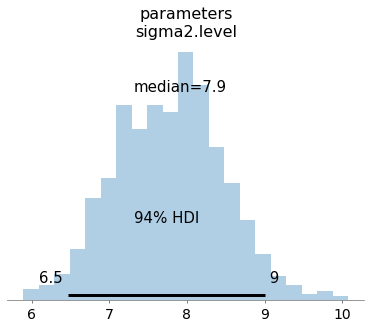

In [3]:
import arviz as az
from scipy import stats
model_rw = sm.tsa.UnobservedComponents(y, 'rwalk')

# Prior distribution
prior = stats.invgamma(0.001, 0.001)

# Perturbation distribution
perturb = stats.norm(scale=0.1)

# Storage
niter = 10000
samples_rw = np.zeros(niter + 1)

# Initialization
samples_rw[0] = y.diff().var()
llf = model_rw.loglike(samples_rw[0])
prior_llf = prior.logpdf(samples_rw[0])

# Iterations
for i in range(1, niter + 1):
    # Compute the proposal value
    proposal = samples_rw[i - 1] + perturb.rvs()
    
    # Compute the acceptance probability
    proposal_llf = model_rw.loglike(proposal)
    proposal_prior_llf = prior.logpdf(proposal)
    accept_prob = np.exp(
        proposal_llf - llf
        + prior_llf - proposal_prior_llf)
    
    # Accept or reject the value
    if accept_prob > stats.uniform.rvs():
        samples_rw[i] = proposal
        llf = proposal_llf
        prior_llf = proposal_prior_llf
    else:
        samples_rw[i] = samples_rw[i - 1]
        
# Convert for use with ArviZ and plot posterior
samples_rw = az.convert_to_inference_data(
    {'parameters': samples_rw[None, ..., None]},
    coords={'parameter': model_rw.param_names},
    dims={'parameters': ['parameter']})
ax = az.plot_posterior(samples_rw.posterior.sel(
    {'draw': np.s_[1000::10]}), kind='bin', point_estimate='median');

## Gibbs sampling

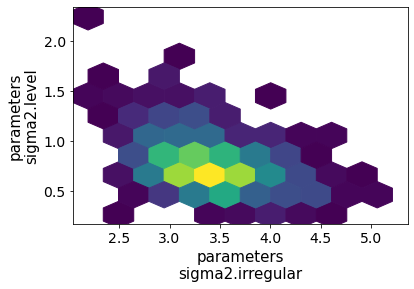

In [4]:
model_ll = sm.tsa.UnobservedComponents(y, 'llevel')

# Construct the simulation smoother
sim_ll = model_ll.simulation_smoother(simulate_state=True)

# Specify the prior distributions. With GS, we
# must choose an inverse Gamma prior for each
# variance
priors = [stats.invgamma(0.01, scale=0.01)] * 2

# Storage
niter = 10000
samples_ll = np.zeros((niter + 1, 2))

# Initialization
samples_ll[0] = [y.diff().var(), 1e-5]

# Iterations
for i in range(1, niter + 1):
    # Update the model parameters
    model_ll.update(samples_ll[i - 1])
    # Draw from the conditional posterior of
    # the state vector
    sim_ll.simulate()
    sample_state = sim_ll.simulated_state.T

    # Compute / draw from conditional posterior of
    # ...observation error variance
    resid = y - sample_state[:, 0]
    post_shape = len(resid) / 2 + 0.01
    post_scale = np.sum(resid**2) / 2 + 0.01
    samples_ll[i, 0] = stats.invgamma(
        post_shape, scale=post_scale).rvs()

    # ...level error variance
    resid = sample_state[1:] - sample_state[:-1]
    post_shape = len(resid) / 2 + 0.01
    post_scale = np.sum(resid**2) / 2 + 0.01
    samples_ll[i, 1] = stats.invgamma(
        post_shape, scale=post_scale).rvs()

# Convert for use with ArviZ and plot posterior
samples_ll = az.convert_to_inference_data(
    {'parameters': samples_ll[None, ...]},
    coords={'parameter': model_ll.param_names},
    dims={'parameters': ['parameter']})
ax = az.plot_pair(samples_ll.posterior.sel(
    {'draw': np.s_[1000::10]}), kind='hexbin');

## Forecasting

In [5]:
def draw_mh_step(mod, ix, params, llf, prior_llf, prior, rw, uniform):
    accept = 0

    proposal = params.copy()
    proposal[ix] += rw.rvs()
    proposal_prior_llf = prior.logpdf(proposal[ix])

    if proposal_prior_llf > -np.inf:
        proposal_llf = mod.loglike(proposal)
        inner = (proposal_llf - llf +
                 proposal_prior_llf - prior_llf)

        if inner > 0:
            acceptance_probability = 1
        else:
            acceptance_probability = np.exp(inner)

        if (acceptance_probability == 1
                or acceptance_probability > uniform.rvs()):
            params[ix] = proposal[ix]
            llf = proposal_llf
            prior_llf = proposal_prior_llf
            accept = 1

    return params[ix], accept, llf, prior_llf


def draw_ig_gs_step(equation, ix, mod, states, prior, state_ix=None):
    if isinstance(prior, (list, tuple)):
        prior_shape = np.array([p.args[0] for p in prior])
        prior_scale = np.array([p.kwds['scale'] for p in prior])
    else:
        prior_shape = prior.args[0]
        prior_scale = prior.kwds['scale']

    if equation == 'observation':
        d = mod['obs_intercept', ix]
        Z = mod['design', ix, :]
        resid = mod.endog[:, ix] - d - states @ Z.T
    elif equation == 'state':
        c = mod['state_intercept', ix]
        T = mod['transition', ix, :]
        resid = states[1:, ix] - c - states[:-1] @ T.T

    squeeze = False
    if resid.ndim == 1:
        squeeze = True
        resid = resid[:, np.newaxis]

    post_shape = np.sum(~np.isnan(resid), axis=0) / 2 + prior_shape
    post_scale = np.nansum(resid**2, axis=0) / 2 + prior_scale
    draw = np.array([stats.invgamma(post_shape[i], scale=post_scale[i]).rvs()
                     for i in range(resid.shape[1])])

    if squeeze:
        draw = draw[0]

    return draw

In [6]:
from pandas_datareader.data import DataReader

indpro = DataReader('IPB50001N', 'fred', start='1980', end='2022-04')['IPB50001N'].asfreq('MS')
indpro.index.name = 'date'

In [7]:
rs = np.random.RandomState()

y = indpro

# Model and state simulation smoother
mod = sm.tsa.UnobservedComponents(y, 'lltrend', seasonal=12, use_exact_diffuse=True)
res_mle = mod.fit(disp=False)
sim = mod.simulation_smoother(simulate_state=True)

# Forecast
n_fcast = 100
ix = pd.date_range(y.index[0], periods=len(y) + n_fcast, freq='MS')
fcast_ix = ix[-n_fcast:]

# Distributions
priors = [stats.invgamma(0.001, scale=0.001)] * 4
rw = [stats.norm(scale=0.01), stats.norm(scale=0.01),
      stats.norm(scale=0.01), stats.norm(scale=0.005)]
uniform = stats.uniform()

# Storage
niter = 2000
nburn = 500
nthin = 2
params_mh = xr.DataArray(np.zeros((niter + 1, mod.k_params)),
                         dims=['draw', 'param'],
                         coords={'param': mod.param_names},
                         name='params')
params = xr.DataArray(np.zeros((niter + 1, mod.k_params)),
                      dims=['draw', 'param'],
                      coords={'param': mod.param_names},
                      name='params')
accepts = xr.DataArray(np.zeros(params.shape, dtype=int),
                       dims=['draw', 'param'],
                       coords={'param': mod.param_names},
                       name='accepts')
states = xr.DataArray(np.zeros((niter + 1, mod.nobs, mod.k_states)),
                      dims=['draw', 'date', 'state'],
                      coords={'date': mod._index.rename('date'),
                              'state': mod.state_names},
                      name='states')
fcast = xr.DataArray(np.zeros((niter + 1, n_fcast, mod.k_endog)),
                     dims=['draw', 'date', 'variable'],
                     coords={'date': fcast_ix,
                             'variable': [mod.endog_names]},
                     name='forecast')

# Initial values
params[0] = mod.fit(disp=False).params
llf = mod.loglike(params[0])
prior_llf = [prior.logpdf(params[0, i])
             for i, prior in enumerate(priors)]

# Iterations
llf = mod.loglike(params[0])
for i in range(1, niter + 1):
    if (i % max(200, niter // 20)) == 0:
        print(i)
        
    # Sample from state posterior
    mod.update(params[i - 1])
    sim.simulate()
    states[i] = sim.simulated_state.T

    # Predictive simulation from sample end
    fcast[i] = mod.simulate(params[i - 1], n_fcast,
                            initial_state=states[i, -1]).to_frame()

    # Gibbs sampling
    params[i, 0] = draw_ig_gs_step('observation', 0, mod, sim.simulated_state.T, priors[0])
    params[i, 1:4] = draw_ig_gs_step('state', [0, 1, 2], mod, sim.simulated_state.T, priors[1:4])


200
400
600
800
1000
1200
1400
1600
1800
2000


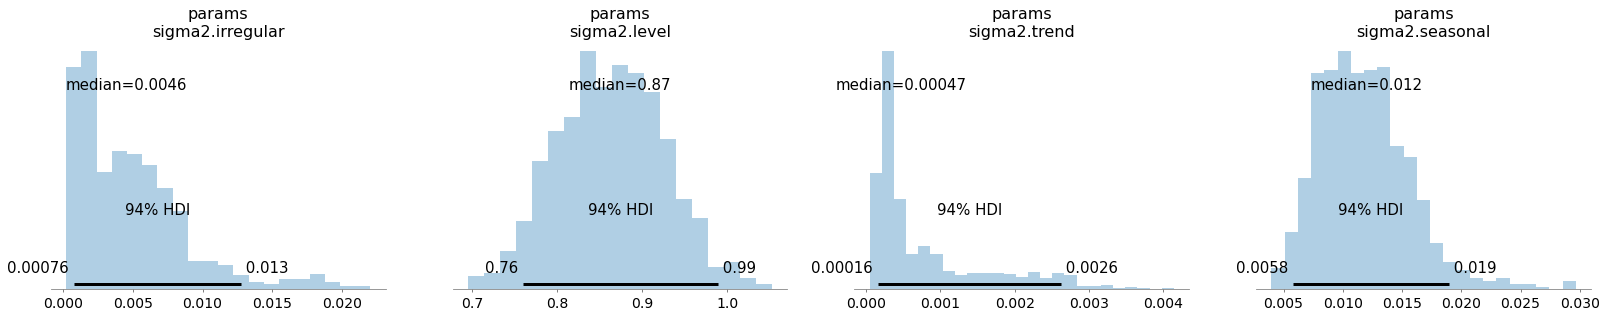

In [8]:
az.plot_posterior(params.sel(draw=np.s_[nburn + 1::nthin]), point_estimate='median', kind='hexbin');

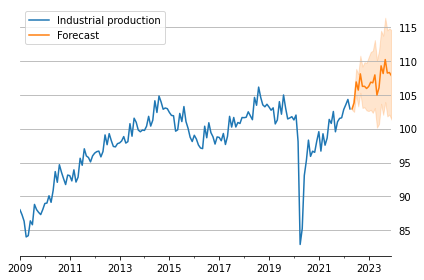

In [9]:
fig, ax = plt.subplots()

ax = y.loc['2009':].rename('Industrial production').plot(ax=ax)
fcast_plot = fcast.sel(draw=np.s_[nburn + 1::nthin], date=np.s_[:'2023-12':])
fcast_plot.median(axis=0).to_pandas()['IPB50001N'].rename('Forecast').plot(ax=ax)
ax.fill_between(fcast_plot.coords['date'].to_index(),
                fcast_plot.quantile(0.1, dim='draw')[:, 0],
                fcast_plot.quantile(0.9, dim='draw')[:, 0],
                color='C1', alpha=0.2)
ax.legend(loc='upper left')
ax.set_xlabel(None)
ax.yaxis.set_label_coords(1, 1)
ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
ax.yaxis.grid()
[ax.spines[s].set_visible(False) for s in ['left', 'top', 'right']]
fig.tight_layout()

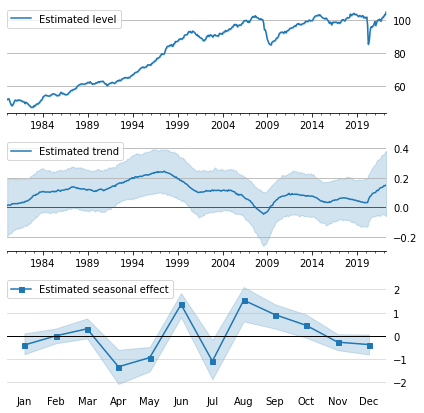

In [10]:
fig, axes = plt.subplots(3, figsize=(6, 6));

states_plot = states.sel(draw=np.s_[nburn + 1::nthin])
level = states_plot.sel(state='level')
trend = states_plot.sel(state='trend')
seasonal = states_plot.sel(state='seasonal')

level.median(axis=0).to_pandas().rename('Estimated level').plot(ax=axes[0])
axes[0].fill_between(level.coords['date'].to_index(),
                     level.quantile(0.1, dim='draw'),
                     level.quantile(0.9, dim='draw'),
                     color='C0', alpha=0.2)
axes[0].legend(loc=(0, 0.80))
axes[0].set_xlabel(None)
axes[0].yaxis.set_label_coords(1, 1)
axes[0].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[0].yaxis.grid()
[axes[0].spines[s].set_visible(False) for s in ['left', 'top', 'right']]


trend.median(axis=0).to_pandas().rename('Estimated trend').plot(ax=axes[1])
axes[1].fill_between(trend.coords['date'].to_index(),
                     trend.quantile(0.1, dim='draw'),
                     trend.quantile(0.9, dim='draw'),
                     color='C0', alpha=0.2)
axes[1].axhline(0, color='k', linestyle='--', linewidth=1, zorder=0)
axes[1].legend(loc=(0, 0.85))
axes[1].set_xlabel(None)
axes[1].yaxis.set_label_coords(1, 1)
axes[1].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[1].yaxis.grid()
axes[1].axhline(0, color='#555', linewidth=1)
[axes[1].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

x = seasonal.T.to_pandas()
x.index = x.index.month.rename('month')
x = x.T.melt()
g = x.groupby('month')
gm = g.median()['value']
gm.index = np.arange(12)
gm.rename('Estimated seasonal effect').plot(ax=axes[2], marker='s', markersize=5)
axes[2].legend(loc=(0, 0.85))
axes[2].fill_between(np.arange(12),
                     g.quantile(0.1)['value'],
                     g.quantile(0.9)['value'],
                     color='C0', alpha=0.2)
axes[2].xaxis.set_ticks(np.arange(0, 12))
axes[2].xaxis.set_ticklabels(pd.period_range('2020', periods=12, freq='M').strftime('%b'))
axes[2].set_xlabel('')
axes[2].axhline(0, color='k', linewidth=1)
axes[2].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[2].yaxis.grid(alpha=0.5)
axes[2].xaxis.set_tick_params(bottom=False)
[axes[2].spines[s].set_visible(False) for s in ['left', 'top', 'right', 'bottom']]

fig.suptitle('')
fig.tight_layout()

## Causal impact

In [11]:
from pandas_datareader.data import DataReader

fredmd = pd.read_csv('fredmd_2022-04.csv').iloc[1:].dropna(how='all')
fredmd.index = pd.DatetimeIndex(fredmd['sasdate'], freq='MS')
CMRMTSPLx = (fredmd.loc['1979':, 'CMRMTSPLx'] / 1000).iloc[1:-1]

In [12]:
rs = np.random.RandomState()

y = CMRMTSPLx.loc[:'2020-02']

# Model and state simulation smoother
mod = sm.tsa.UnobservedComponents(y, 'lltrend', use_exact_diffuse=True)
res_mle = mod.fit(disp=False)
sim = mod.simulation_smoother(simulate_state=True)

# Forecast
n_fcast = len(CMRMTSPLx) - len(y)
ix = CMRMTSPLx.index.rename('date')
fcast_ix = ix[-n_fcast:]

# Distributions
priors = [stats.invgamma(0.001, scale=0.001)] * 3
rw = [stats.norm(scale=0.01), stats.norm(scale=0.01)]
uniform = stats.uniform()

# Storage
niter = 2000
nburn = 500
nthin = 4
params_mh = xr.DataArray(np.zeros((niter + 1, mod.k_params)),
                         dims=['draw', 'param'],
                         coords={'param': mod.param_names},
                         name='params')
params = xr.DataArray(np.zeros((niter + 1, mod.k_params)),
                      dims=['draw', 'param'],
                      coords={'param': mod.param_names},
                      name='params')
accepts = xr.DataArray(np.zeros(params.shape, dtype=int),
                       dims=['draw', 'param'],
                       coords={'param': mod.param_names},
                       name='accepts')
states = xr.DataArray(np.zeros((niter + 1, mod.nobs, mod.k_states)),
                      dims=['draw', 'date', 'state'],
                      coords={'date': mod._index.rename('date'),
                              'state': mod.state_names},
                      name='states')
predict = xr.DataArray(np.zeros((niter + 1, mod.nobs + n_fcast, mod.k_endog)),
                       dims=['draw', 'date', 'variable'],
                       coords={'date': ix,
                               'variable': [mod.endog_names]},
                       name='forecast')

# Initial values
params[0] = mod.fit(disp=False).params
llf = mod.loglike(params[0])
prior_llf = [prior.logpdf(params[0, i])
             for i, prior in enumerate(priors)]

# Iterations
llf = mod.loglike(params[0])
for i in range(1, niter + 1):
    if (i % max(200, niter // 20)) == 0:
        print(i)
        
    # Sample from state posterior
    mod.update(params[i - 1])
    sim.simulate()
    states[i] = sim.simulated_state.T

    # Predictive simulation
    in_sample = pd.Series(
        (mod['design'] @ sim.simulated_state)[0].T,
        index=y.index)
    out_of_sample = mod.simulate(params[i - 1], n_fcast,
                                 initial_state=states[i, -1])
    predict[i] = pd.concat([in_sample, out_of_sample]).to_frame()

    # Gibbs sampling
    params[i, 0] = draw_ig_gs_step('observation', 0, mod, sim.simulated_state.T, priors[0])
    params[i, 1:] = draw_ig_gs_step('state', [0], mod, sim.simulated_state.T, priors[1:])


200
400
600
800
1000
1200
1400
1600
1800
2000


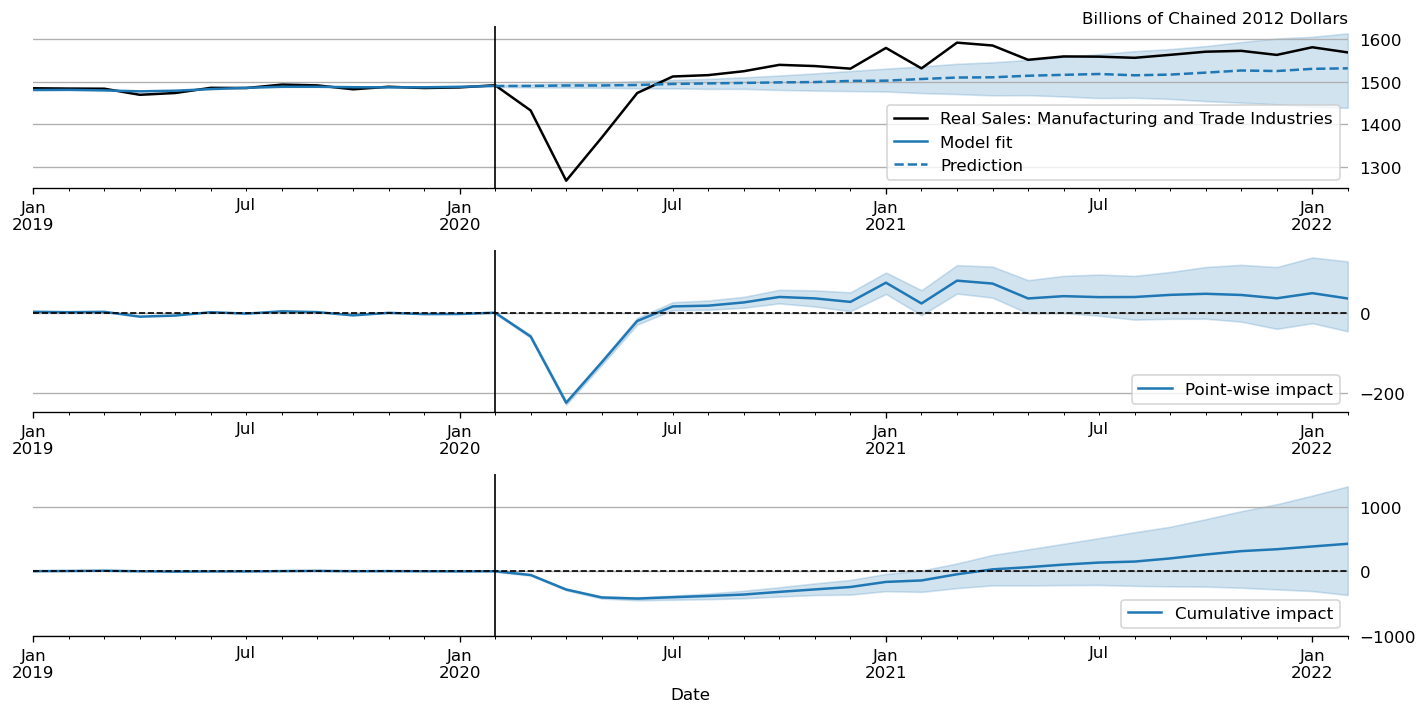

In [13]:
fig, axes = plt.subplots(3, figsize=(12, 6), dpi=120)

start = '2019'

predict_plot = predict.sel(draw=np.s_[nburn + 1::nthin])
predict_median = predict_plot.median(dim='draw').to_pandas().iloc[:, 0]
predict_lower = predict_plot.quantile(0.3, dim='draw').sel(date=np.s_['2020-02':])[:, 0]
predict_upper = predict_plot.quantile(0.7, dim='draw').sel(date=np.s_['2020-02':])[:, 0]

predict_diff = (xr.DataArray(CMRMTSPLx.to_frame(), dims=['date', 'variable']) - predict_plot)
predict_diff_median = predict_diff.median(dim='draw').to_pandas().iloc[:, 0]
predict_diff_lower = predict_diff.quantile(0.3, dim='draw').sel(date=np.s_['2020-02':])[:, 0]
predict_diff_upper = predict_diff.quantile(0.7, dim='draw').sel(date=np.s_['2020-02':])[:, 0]

predict_diff_cumul = predict_diff.loc[start:].cumsum(dim='date')
predict_diff_cumul_median = predict_diff_cumul.median(dim='draw').to_pandas().iloc[:, 0]
predict_diff_cumul_lower = predict_diff_cumul.quantile(0.3, dim='draw').sel(date=np.s_['2020-02':])[:, 0]
predict_diff_cumul_upper = predict_diff_cumul.quantile(0.7, dim='draw').sel(date=np.s_['2020-02':])[:, 0]

CMRMTSPLx.loc[start:].rename('Real Sales: Manufacturing and Trade Industries').plot(color='k', ax=axes[0])
predict_median.loc[start:'2020-02'].rename('Model fit').plot(ax=axes[0])
predict_median.loc['2020-02':].rename('Prediction').plot(ax=axes[0], color='C0', linestyle='--')
axes[0].fill_between(predict_lower.coords['date'].to_index(),
                     predict_lower,
                     predict_upper,
                     color='C0', alpha=0.2)
axes[0].legend(loc='lower right')
axes[0].axvline('2020-02', color='k', linewidth=1)
axes[0].set_ylabel('Billions of Chained 2012 Dollars', loc='top', rotation="horizontal")
axes[0].set_xlabel(None)
axes[0].yaxis.set_label_coords(1, 1)
axes[0].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[0].yaxis.grid()
[axes[0].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

predict_diff_median.loc[start:].rename('Point-wise impact').plot(ax=axes[1])
axes[1].fill_between(predict_diff_lower.coords['date'].to_index(),
                     predict_diff_lower,
                     predict_diff_upper,
                     color='C0', alpha=0.2)
axes[1].axvline('2020-02', color='k', linewidth=1)
axes[1].axhline(0, color='k', linewidth=1, linestyle='--')
axes[1].legend(loc='lower right')
axes[1].set_xlabel(None)
axes[1].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[1].yaxis.grid()
[axes[1].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

predict_diff_cumul_median.loc[start:].rename('Cumulative impact').plot(ax=axes[2])
axes[2].fill_between(predict_diff_cumul_lower.coords['date'].to_index(),
                     predict_diff_cumul_lower,
                     predict_diff_cumul_upper,
                     color='C0', alpha=0.2)
axes[2].axvline('2020-02', color='k', linewidth=1)
axes[2].axhline(0, color='k', linewidth=1, linestyle='--')
axes[2].legend(loc='lower right')
axes[2].set_ylim(-1000, 1500)
axes[2].set_xlabel('Date')
axes[2].yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=True)
axes[2].yaxis.grid()
[axes[2].spines[s].set_visible(False) for s in ['left', 'top', 'right']]

fig.tight_layout()